## Heirarchical Drift Diffusion Model Analysis

In this script, we fit a version of the diffusion model that takes participant-level variabibility into account. As Wiecki et al. (2013) put it, 

"Hierarchical Bayesian methods provide a remedy for this problem by allowing group and subject parameters to be estimated simultaneously at different hierarchical levels ([LeeWagenmakers13], [Kruschke10], [VandekerckhoveTuerlinckxLee11]). Subject parameters are assumed to be drawn from a group distribution, and to the degree that subject are similar to each other, the variance in the group distribution will be estimated to be small, which reciprocally has a greater influence on constraining parameter estimates of any individual. Even in this scenario, the method still allows the posterior for any given individual subject to differ substantially from that of the rest of the group given sufficient data to overwhelm the group prior. Thus the method capitalizes on statistical strength shared across the individuals, and can do so to different degrees even within the same sample and model, depending on the extent to which subjects are similar to each other in one parameter vs. another."

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hddm
%matplotlib inline

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [75]:
# Loading and arranging data for analysis
data = hddm.load_csv("../../../data/3_final_merged_data/ewma_output/speed_acc_kids_trio_ewma_results.csv")
data = data.dropna(subset = ['RT'])
data['subj_idx'] = data['Sub.Num']
data['rt'] = data['RT']
data['response'] = data['correct']

In [76]:
# Separate adult and kid data
data_kids = data[data.age_code == "child"]
# filter to remove extreme RTs
data_kids = data_kids[(data_kids.guess == "response")]
# remove object and bullseye data
data_kids = data_kids[(data_kids['stimuli'] == "Face") | (data_kids['stimuli'] == "ASL") ]

In [77]:
data_kids = hddm.utils.flip_errors(data_kids)
data_kids.head(5)

,Sub.Num,Tr.Num,stimuli,age_code,correct,Months,RT,condition,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
77,30047,15,ASL,child,1,35,0.733,ASL,0.733,response,1,0.01,cs,0.57,30047,1
78,30010,13,ASL,child,1,44,0.767,ASL,0.767,response,1,0.01,cs,0.57,30010,1
82,30019,18,ASL,child,1,29,0.767,ASL,0.767,response,1,0.01,cs,0.57,30019,1
84,30019,24,ASL,child,1,29,0.767,ASL,0.767,response,1,0.01,cs,0.57,30019,1
85,30019,26,ASL,child,1,29,0.767,ASL,0.767,response,1,0.01,cs,0.57,30019,1


## Fit variable drift model

Here we fit the ddm for each participant, but now we allow the drift rate to vary across the four conditions. We also consider the possibility that 5% of the data could be generated by a different process (i.e., outliers). From the HDDM documentation:

"What we can do instead is fit a mixture model which assumes that outliers come from a uniform distribution. (Note, outliers do not have to be very fast or very slow, and the above example is just an obvious illustration. Some proportion of the trials can be assumed to simply come from a different process for which we make no assumptions about its generation, and hence use a uniform distribution. This allows the model to find the best DDM parameters that capture the majority of trials). Here, we specify that we expect roughly 5% outliers in our data."

In [78]:
m_stim = hddm.HDDM(data_kids, depends_on={'v': 'stimuli', 'a': 'stimuli'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=100)

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10000 of 10000 complete in 685.8 sec

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


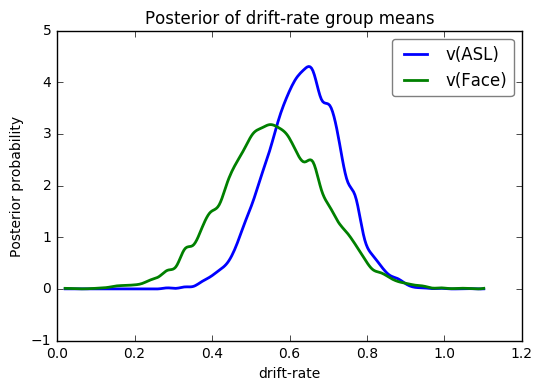

In [79]:
drift_ASL, drift_Face = m_stim.nodes_db.node[['v(ASL)', 'v(Face)']]
hddm.analyze.plot_posterior_nodes([drift_ASL, drift_Face])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

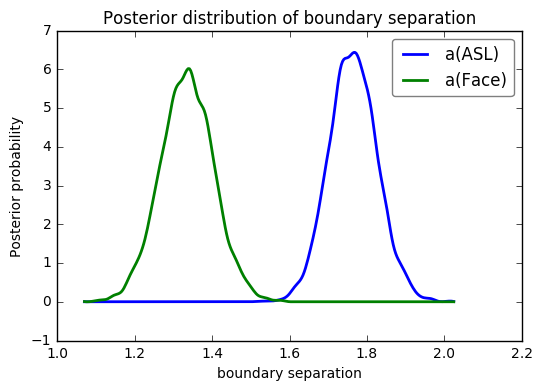

In [81]:
boundary_ASL, boundary_Face = m_stim.nodes_db.node[['a(ASL)', 'a(Face)']]
hddm.analyze.plot_posterior_nodes([boundary_ASL, boundary_Face])
plt.xlabel('boundary separation')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of boundary separation')

In [82]:
# write variable drift and boundary separation model output to csv
drift_ASL.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/drift_asl.csv", sep=',', format='%10.5f')
drift_Face.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/drift_face.csv", sep=',', format='%10.5f')
boundary_Face.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/boundary_face.csv", sep=',', format='%10.5f')
boundary_ASL.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/boundary_asl.csv", sep=',', format='%10.5f')

# Fit HDDM to kid gaze data

Next, we fit the same HDDM for the kid data from two experiments manipulating the presence of gaze after the noun cue.

In [83]:
# Loading and arranging data for analysis
data_kid_gaze = hddm.load_csv("../../../data/3_final_merged_data/ewma_output/speed_acc_kids_gaze_ewma_results.csv")
data_kid_gaze = data_kid_gaze.dropna(subset = ['rt'])
data_kid_gaze['subj_idx'] = data_kid_gaze['subid']
data_kid_gaze['response'] = data_kid_gaze['correct']

In [84]:
# filter to remove guesses as flagged by the EWMA model
data_kid_gaze = data_kid_gaze[(data_kid_gaze.guess == "response")]
data_kid_gaze = hddm.utils.flip_errors(data_kid_gaze)
data_kid_gaze.head(5)

,subid,tr.num,gaze_condition,correct,age,age_group,RT,condition,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
212,25,7,gaze,1,1929.0,5,0.442,gaze,0.44,response,1,0.01,cs,0.58,25,1
213,26,7,gaze,1,1789.0,4,0.442,gaze,0.44,response,1,0.01,cs,0.58,26,1
214,34,25,gaze,1,2016.0,5,0.442,gaze,0.44,response,1,0.02,cs,0.59,34,1
215,45,13,gaze,1,NaN,3,0.442,gaze,0.44,response,1,0.02,cs,0.59,45,1
216,15,8,gaze,1,1077.0,2,0.467,gaze,0.47,response,1,0.02,cs,0.59,15,1


In [85]:
# fit model for kid gaze data
m_kid_gaze = hddm.HDDM(data_kid_gaze, depends_on={'v': 'condition', 'a': 'condition', 't': 'condition'})
m_kid_gaze.find_starting_values()
m_kid_gaze.sample(10000, burn=100)

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10001 of 10000 complete in 746.9 sec

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


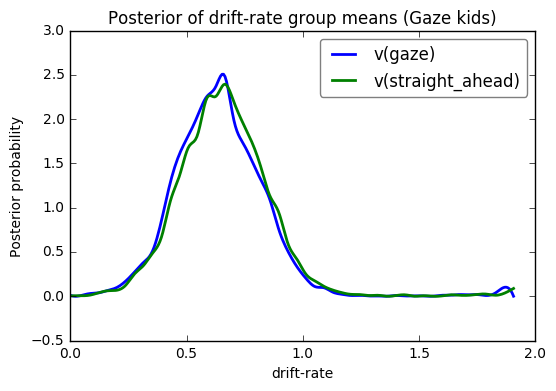

In [86]:
# plot drift
drift_gaze_kid, drift_straight_ahead_kid = m_kid_gaze.nodes_db.node[['v(gaze)', 'v(straight_ahead)']]
hddm.analyze.plot_posterior_nodes([drift_gaze_kid, drift_straight_ahead_kid])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means (Gaze kids)')

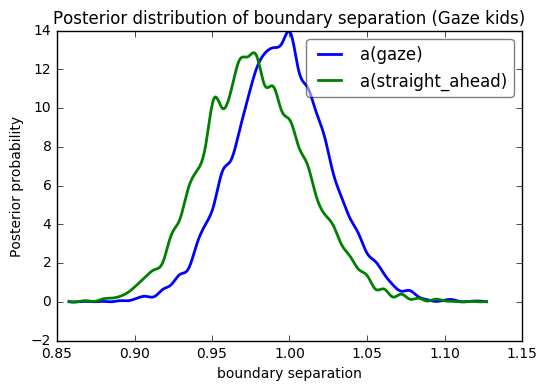

In [89]:
# plot boundary
boundary_gaze_kid, boundary_straight_ahead_kid = m_kid_gaze.nodes_db.node[['a(gaze)', 'a(straight_ahead)']]
hddm.analyze.plot_posterior_nodes([boundary_gaze_kid, boundary_straight_ahead_kid])
plt.xlabel('boundary separation')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of boundary separation (Gaze kids)')

In [90]:
# write variable drift and boundary separation model output to csv
drift_gaze_kid.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/drift_gaze.csv", sep=',', format='%10.5f')
drift_straight_ahead_kid.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/drift_straightahead.csv", sep=',', format='%10.5f')
boundary_gaze_kid.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/boundary_gaze.csv", sep=',', format='%10.5f')
boundary_straight_ahead_kid.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/boundary_straightahead.csv", sep=',', format='%10.5f')

# Fit HDDM to kid noise data

Next, we fit the same HDDM for the kid data from two experiments manipulating the presence of gaze after the noun cue.

In [91]:
# read data
data_kid_noise = hddm.load_csv("../../../data/3_final_merged_data/ewma_output/speed_acc_kids_noise_ewma_results.csv")
data_kid_noise = data_kid_noise.dropna(subset = ['rt'])
data_kid_noise['subj_idx'] = data_kid_noise['subid']
data_kid_noise['response'] = data_kid_noise['correct']

# filter to remove guesses as flagged by the EWMA model
data_kid_noise = data_kid_noise[(data_kid_noise.guess == "response")]
data_kid_noise = hddm.utils.flip_errors(data_kid_noise)
data_kid_noise.head(5)

,subid,tr.num,noise_condition,correct,age,age_group,RT,condition,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
290,19,11,clear,1,1129.0,3,0.572,clear,0.57,response,1,0.01,cs,0.58,19,1
292,43,24,clear,1,NaN,3,0.573,clear,0.57,response,1,0.01,cs,0.58,43,1
293,37,7,clear,1,NaN,5,0.576,clear,0.58,response,1,0.01,cs,0.58,37,1
294,43,27,clear,1,NaN,3,0.600,clear,0.60,response,1,0.02,cs,0.59,43,1
295,28,13,clear,1,NaN,3,0.602,clear,0.60,response,1,0.02,cs,0.59,28,1


In [92]:
# fit model for kid noise data
m_kid_noise = hddm.HDDM(data_kid_noise, depends_on={'v': 'condition', 'a': 'condition', 't': 'condition'})
m_kid_noise.find_starting_values()
m_kid_noise.sample(10000, burn=100)

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10000 of 10000 complete in 788.6 sec

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


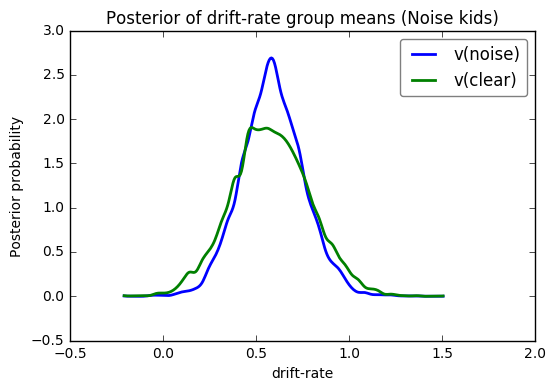

In [93]:
# plot drift
drift_noise_kid, drift_clear_kid = m_kid_noise.nodes_db.node[['v(noise)', 'v(clear)']]
hddm.analyze.plot_posterior_nodes([drift_noise_kid, drift_clear_kid])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means (Noise kids)')

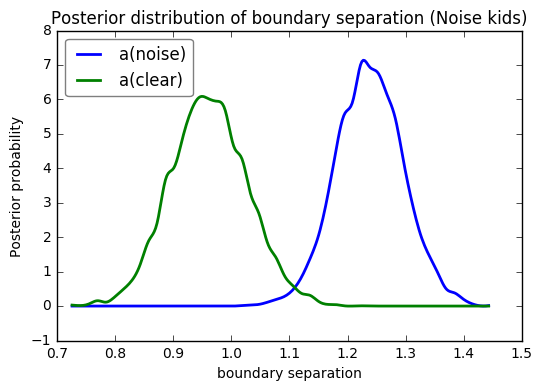

In [94]:
# plot boundary
boundary_noise_kid, boundary_clear_kid = m_kid_noise.nodes_db.node[['a(noise)', 'a(clear)']]
hddm.analyze.plot_posterior_nodes([boundary_noise_kid, boundary_clear_kid])
plt.xlabel('boundary separation')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of boundary separation (Noise kids)')

In [95]:
# write variable drift and boundary separation model output to csv
drift_noise_kid.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/drift_noise.csv", sep=',', format='%10.5f')
drift_clear_kid.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/drift_clear.csv", sep=',', format='%10.5f')
boundary_noise.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/boundary_noise.csv", sep=',', format='%10.5f')
boundary_clear.trace().tofile("../../../data/3_final_merged_data/hddm_output/kids/boundary_clear.csv", sep=',', format='%10.5f')

# Fit HDDM to adult text data

Next, we fit the same HDDM for the adult data with the four different center stimulus types: face, bullseye, text, and text-no-audio

In [96]:
# read data
data_adults = hddm.load_csv("../../../data/3_final_merged_data/ewma_output/speed_acc_adult_text_ewma_results.csv")
data_adults = data_adults.dropna(subset = ['RT'])
data_adults['subj_idx'] = data_adults['subid']
data_adults['rt'] = data_adults['RT']
data_adults['response'] = data_adults['correct']

# filter to remove guesses as flagged by the EWMA model
data_adults = data_adults[(data_adults.guess == "response")]
data_adults = hddm.utils.flip_errors(data_adults)
data_adults.head(5)

,subid,tr.num,condition,correct,RT,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
194,11_02_05,52,bullseye,1,0.497,0.497,response,1,0.01,cs,0.62,11_02_05,1
195,11_02_07,44,bullseye,1,0.497,0.497,response,1,0.01,cs,0.62,11_02_07,1
196,11_02_08,27,bullseye,1,0.497,0.497,response,1,0.01,cs,0.62,11_02_08,1
197,11_02_08,30,bullseye,1,0.497,0.497,response,1,0.02,cs,0.63,11_02_08,1
198,11_02_08,36,bullseye,1,0.497,0.497,response,1,0.02,cs,0.63,11_02_08,1


In [97]:
# fit model for adult data
m_adults = hddm.HDDM(data_adults, depends_on={'v': 'condition', 'a': 'condition', 't': 'condition'})
m_adults.find_starting_values()
m_adults.sample(10000, burn=100)

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10000 of 10000 complete in 1014.1 sec

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


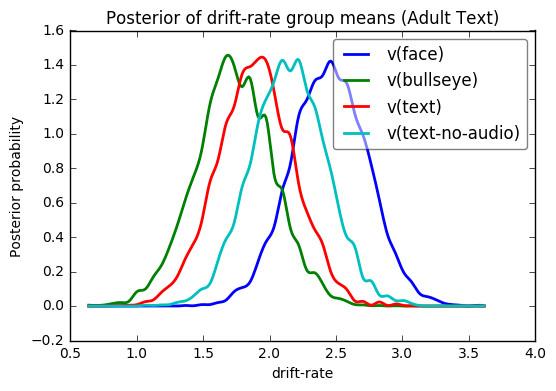

In [98]:
# plot drift
drift_face_adult, drift_bull_adult, drift_text_adult, drift_text_no_audio_adult = m_adults.nodes_db.node[['v(face)', 'v(bullseye)', 'v(text)', 'v(text-no-audio)']]
hddm.analyze.plot_posterior_nodes([drift_face_adult, drift_bull_adult, drift_text_adult, drift_text_no_audio_adult])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means (Adult Text)')

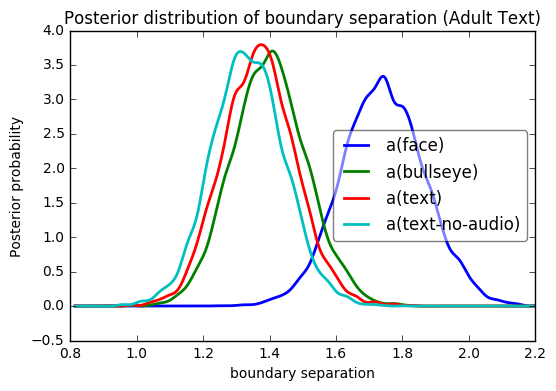

In [99]:
# plot boundary separation
boundary_face_adult, boundary_bull_adult, boundary_text_adult, boundary_text_no_audio_adult = m_adults.nodes_db.node[['a(face)', 'a(bullseye)', 'a(text)', 'a(text-no-audio)']]
hddm.analyze.plot_posterior_nodes([boundary_face_adult, boundary_bull_adult, boundary_text_adult, boundary_text_no_audio_adult])
plt.xlabel('boundary separation')
plt.ylabel('Posterior probability')
plt.title('Posterior distribution of boundary separation (Adult Text)')

In [100]:
# write variable drift model output to csv
drift_face_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_face_adult.csv", sep=',', format='%10.5f')
drift_bull_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_bull_adult.csv", sep=',', format='%10.5f')
drift_text_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_text_adult.csv", sep=',', format='%10.5f')
drift_text_no_audio_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_text_no_audio_adult.csv", sep=',', format='%10.5f')
# write boundary separation
boundary_face_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_face_adult.csv", sep=',', format='%10.5f')
boundary_bull_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_bull_adult.csv", sep=',', format='%10.5f')
boundary_text_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_text_adult.csv", sep=',', format='%10.5f')
boundary_text_no_audio_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_text_no_audio_adult.csv", sep=',', format='%10.5f')

# Fit HDDM to adult noise & gaze data

Next, we fit the same HDDM for the adult data with the four different conditions: noise_gaze, noise_straight_ahead, clear_gaze, clear_straight_ahead.

In [2]:
# read data
data_adults_ng = hddm.load_csv("../../../data/3_final_merged_data/ewma_output/speed_acc_adult_ng_ewma_results.csv")
data_adults_ng = data_adults_ng.dropna(subset = ['RT'])
data_adults_ng['subj_idx'] = data_adults_ng['subid']
data_adults_ng['response'] = data_adults_ng['correct']

# filter to remove guesses as flagged by the EWMA model
data_adults_ng = data_adults_ng[(data_adults_ng.guess == "response")]
data_adults_ng = hddm.utils.flip_errors(data_adults_ng)
data_adults_ng.head(5)

,subid,tr.num,condition_long,correct,RT,condition,rt,guess,guess_num,ucl_bound,ewma_param,param_value,subj_idx,response
47,13,30,gaze_clear,1,0.310,gaze_clear,0.31,response,1,0.01,cs,0.59,13,1
48,33,35,gaze_clear,1,0.335,gaze_clear,0.34,response,1,0.01,cs,0.59,33,1
49,15,26,gaze_clear,1,0.336,gaze_clear,0.34,response,1,0.02,cs,0.60,15,1
50,20,63,gaze_clear,1,0.336,gaze_clear,0.34,response,1,0.01,cs,0.60,20,1
51,21,42,gaze_clear,1,0.337,gaze_clear,0.34,response,1,0.02,cs,0.61,21,1


In [3]:
# fit model for adult data
m_adults_ng = hddm.HDDM(data_adults_ng, depends_on={'v': 'condition', 'a': 'condition', 't': 'condition'})
m_adults_ng.find_starting_values()
m_adults_ng.sample(5000, burn=100)

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 5000 of 5000 complete in 697.4 sec

/Users/kmacdonald/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


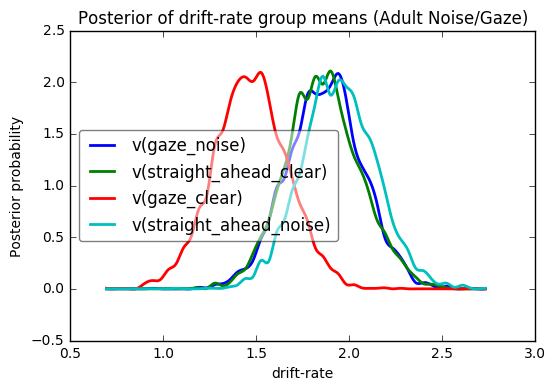

In [4]:
# plot drift
drift_gaze_noise_adult, drift_straight_ahead_clear_adult, drift_gaze_clear_adult, drift_straight_ahead_noise_adult = m_adults_ng.nodes_db.node[['v(gaze_noise)', 'v(straight_ahead_clear)', 'v(gaze_clear)', 'v(straight_ahead_noise)']]
hddm.analyze.plot_posterior_nodes([drift_gaze_noise_adult, drift_straight_ahead_clear_adult, drift_gaze_clear_adult, drift_straight_ahead_noise_adult])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means (Adult Noise/Gaze)')

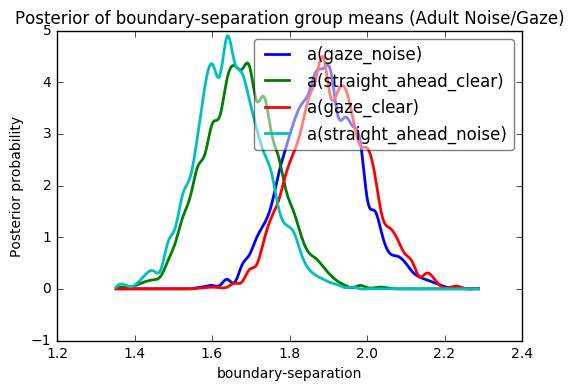

In [5]:
# plot boundary
boundary_gaze_noise_adult, boundary_straight_ahead_clear_adult, boundary_gaze_clear_adult, boundary_straight_ahead_noise_adult = m_adults_ng.nodes_db.node[['a(gaze_noise)', 'a(straight_ahead_clear)', 'a(gaze_clear)', 'a(straight_ahead_noise)']]
hddm.analyze.plot_posterior_nodes([boundary_gaze_noise_adult, boundary_straight_ahead_clear_adult, boundary_gaze_clear_adult, boundary_straight_ahead_noise_adult])
plt.xlabel('boundary-separation')
plt.ylabel('Posterior probability')
plt.title('Posterior of boundary-separation group means (Adult Noise/Gaze)')

In [7]:
# write variable drift model output to csv
drift_gaze_noise_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_gaze_noise_adult.csv", sep=',', format='%10.5f')
drift_straight_ahead_clear_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_straight_ahead_clear_adult.csv", sep=',', format='%10.5f')
drift_gaze_clear_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_gaze_clear_adult.csv", sep=',', format='%10.5f')
drift_straight_ahead_noise_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/drift_straight_ahead_noise_adult.csv", sep=',', format='%10.5f')
# write boundary separation
boundary_gaze_noise_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_gaze_noise_adult.csv", sep=',', format='%10.5f')
boundary_straight_ahead_clear_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_straight_ahead_clear_adult.csv", sep=',', format='%10.5f')
boundary_gaze_clear_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_gaze_clear_adult.csv", sep=',', format='%10.5f')
boundary_straight_ahead_noise_adult.trace().tofile("../../../data/3_final_merged_data/hddm_output/adults/boundary_straight_ahead_noise_adult.csv", sep=',', format='%10.5f')